## Import packages

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

## Load evaluation score

In [3]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [4]:
input_dir = '../../data/eval_important_evo'
# models = ['inception_v3-512-0.5-0.9', 'vgg16-512-0.01-0.9']
models = ['inception_v3-512-0.5-0.9']

### InceptionV3, 11->121, freezing

In [118]:
def make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos, eps=0.5):
    for model in models:
        data_dir = os.path.join(input_dir, model, 'data')
        model_data = {
            'from': {},
            'to': {},
            eval_type: {}
        }
        from_to = from_tos[model]
        for ratio in eval_sample_ratios:
            # File path
            settings = [
                ['eval_important_evo-option', eval_type],
                ['label', label],
                ['eps', eps],
                ['eval_sample_ratio', ratio],
                ['from', from_to[0]],
                ['to', from_to[1]]
            ]
            file_path = os.path.join(
                data_dir, 
                '-'.join(['{}={}'.format(s[0], s[1]) for s in settings]) + '.json'
            )
            data = load_json(file_path)

            # Initialize data
            agg_data = {
                'from': data['from'],
                'to': data['to'],
                'important': {
                    'top1': {'correct': 0, 'incorrect': 0},
                    'topk': {'correct': 0, 'incorrect': 0},
                },
                'least-important': {
                    'top1': {'correct': 0, 'incorrect': 0},
                    'topk': {'correct': 0, 'incorrect': 0},
                },
                'random': {
                    'top1': {'correct': 0, 'incorrect': 0},
                    'topk': {'correct': 0, 'incorrect': 0},
                }
            }

            # Aggregate data of all layers
            layers = list(data['important'].keys())
            for key in ['important', 'least-important', 'random']:
                for layer in layers:
                    for inner_key in ['top1', 'topk']:
                        for val_type in ['correct', 'incorrect']:
                            agg_data[key][inner_key][val_type] += data[key][layer][inner_key][val_type]

            # Compute score
            for key in agg_data:
                for inner_key in ['top1', 'topk']:
                    corrects = agg_data[key][inner_key]['correct']
                    incorrects = agg_data[key][inner_key]['incorrect']
                    score = corrects / (corrects + incorrects)
                    agg_data[key][inner_key]['acc'] = score

            # Save score
            model_data['from'] = data['from']
            model_data['to'] = data['to']
            model_data[eval_type][ratio] = {}
            for key in ['important', 'least-important', 'random']:
                model_data[eval_type][ratio][key] = agg_data[key]
    
    return model_data
                
    
def draw_graph(label, model_data, eval_type='freezing', eps=0.5):
    # Draw plots
    for key in ['top1', 'topk']:
        for model in models:

            # Draw baseline
            ratios = list(model_data[eval_type].keys())
            for inner_key in ['from', 'to']:
            # for inner_key in ['to']:
                vals = [model_data[inner_key][key]['acc']] * len(ratios)
                plt.plot(ratios, vals, 'o--', label=inner_key)

            # Draw values by sample ratio
            for inner_key in ['important', 'least-important', 'random']:
                vals = [model_data[eval_type][ratio][inner_key][key]['acc'] for ratio in ratios]
                plt.plot(ratios, vals, 'o--', label=inner_key)

            # Legend
            title = 'label={}, {}'.format(label, key)
            if eval_type == 'perturbation':
                title += ', eps={}'.format(eps)
            plt.title(title)
            plt.legend()
            plt.show()


In [92]:
eps = 0.5 # It is not used for freezing version

eval_type = 'freezing'
eval_sample_ratios = [0.1, 0.3, 0.5, 0.7]
from_tos = {
    'inception_v3-512-0.5-0.9': ['inception_v3_512_0.5_0.9_11', 'inception_v3_512_0.5_0.9_121'],
    'vgg16-512-0.01-0.9': ['vgg16_512_0.01_0.9_21', 'vgg16_512_0.01_0.9_207']
}

In [116]:
def draw_avg_graph(labels, input_dir, model, eval_type, eval_sample_ratios, from_tos):
    avg_data = {
        'from': {
            'top1': {'correct': 0, 'incorrect': 0},
            'topk': {'correct': 0, 'incorrect': 0},
        },
        'to': {
            'top1': {'correct': 0, 'incorrect': 0},
            'topk': {'correct': 0, 'incorrect': 0},
        },
        eval_type: {}
    }
    
    for label in labels:
        model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
        ratios = list(model_data[eval_type].keys())
        if len(avg_data[eval_type]) == 0:
            for ratio in ratios:
                avg_data[eval_type][ratio] = {}
                for key in ['important', 'least-important', 'random']:
                    avg_data[eval_type][ratio][key] = {
                        'top1': {'correct': 0, 'incorrect': 0},
                        'topk': {'correct': 0, 'incorrect': 0},
                    }
                    
        # Collect data from baseline
        for key in ['from', 'to']:
            for inner_key in ['top1', 'topk']:
                for val_type in ['correct', 'incorrect']:
                    avg_data[key][inner_key][val_type] += model_data[key][inner_key][val_type]
                    
        # Collect data
        for ratio in ratios:
            for key in ['important', 'least-important', 'random']:
                for inner_key in ['top1', 'topk']:
                    for val_type in ['correct', 'incorrect']:
                        avg_data[eval_type][ratio][key][inner_key][val_type] += model_data[eval_type][ratio][key][inner_key][val_type]
                        
        # Compute score of baselines
        for key in ['from', 'to']:
            for inner_key in ['top1', 'topk']:
                correct = avg_data[key][inner_key]['correct']
                incorrect = avg_data[key][inner_key]['incorrect']
                acc = correct / (correct + incorrect)
                avg_data[key][inner_key]['acc'] = acc
                
        # Compute score of data
        for ratio in ratios:
            for key in ['important', 'least-important', 'random']:
                for inner_key in ['top1', 'topk']:
                    correct = avg_data[eval_type][ratio][key][inner_key]['correct']
                    incorrect = avg_data[eval_type][ratio][key][inner_key]['incorrect']
                    acc = correct / (correct + incorrect)
                    avg_data[eval_type][ratio][key][inner_key]['acc'] = acc
        
    # Draw graph
    for key in ['top1', 'topk']:

        # Draw baseline
        # for inner_key in ['from', 'to']:
        for inner_key in ['to']:
            vals = [avg_data[inner_key][key]['acc']] * len(ratios)
            plt.plot(ratios, vals, 'o--', label=inner_key)

        # Draw values by sample ratio
        for inner_key in ['important', 'least-important', 'random']:
            vals = [avg_data[eval_type][ratio][inner_key][key]['acc'] for ratio in ratios]
            plt.plot(ratios, vals, 'o--', label=inner_key)

        # Legend
        title = '{}, labels={}'.format(key, labels)
        if eval_type == 'perturbation':
            title += ', eps={}'.format(eps)
            
        plt.ylabel('train accuracy')
        plt.xlabel('sample rate (freezed evolution)')
        plt.title(title)
        plt.legend()
        plt.show()

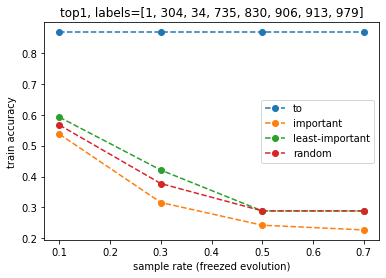

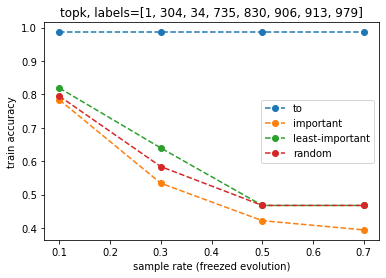

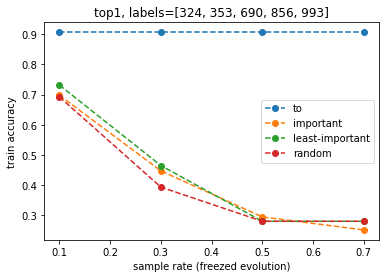

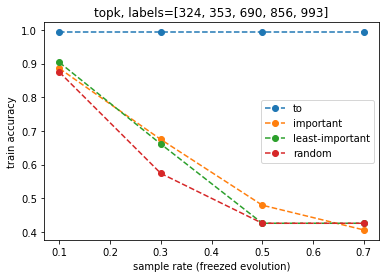

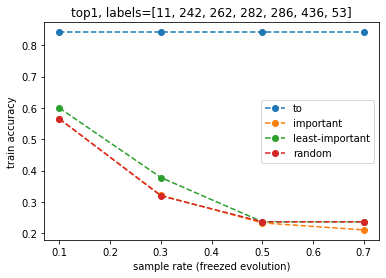

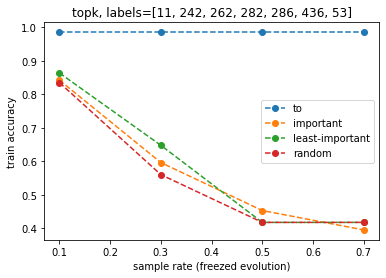

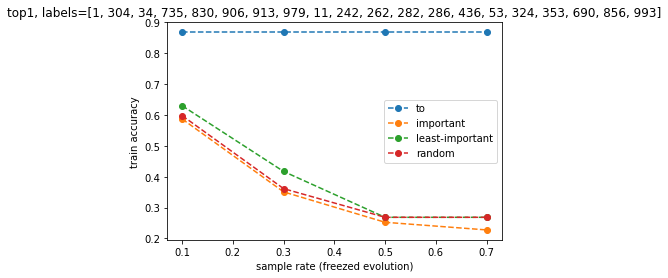

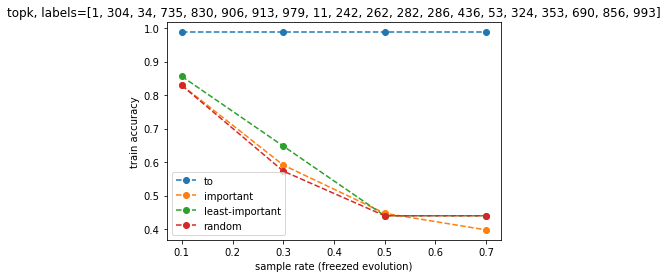

In [117]:
good_labels = [1, 304, 34, 735, 830, 906, 913, 979]
soso_labels = [11, 242, 262, 282, 286, 436, 53]
bad_labels = [324, 353, 690, 856, 993]
all_labels = good_labels + soso_labels + bad_labels

draw_avg_graph(good_labels, input_dir, model, eval_type, eval_sample_ratios, from_tos)
draw_avg_graph(bad_labels, input_dir, model, eval_type, eval_sample_ratios, from_tos)
draw_avg_graph(soso_labels, input_dir, model, eval_type, eval_sample_ratios, from_tos)
draw_avg_graph(all_labels, input_dir, model, eval_type, eval_sample_ratios, from_tos)

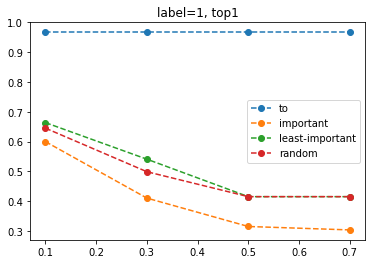

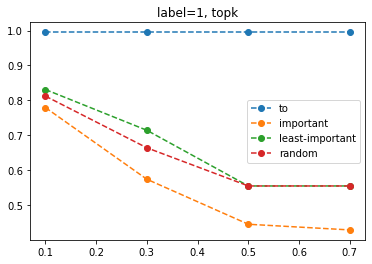

In [46]:
label = 1
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

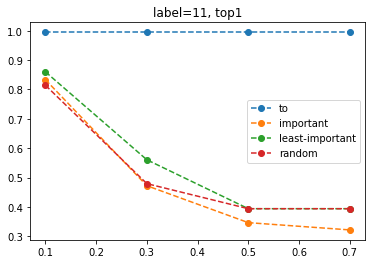

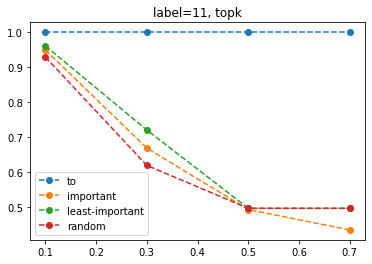

In [47]:
label = 11
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

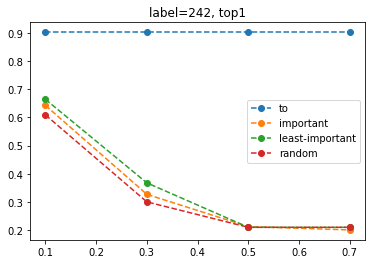

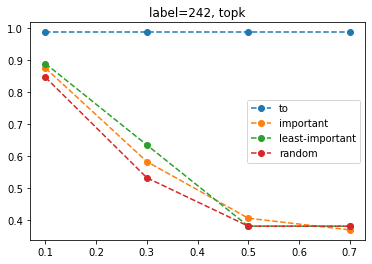

In [52]:
label = 242
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

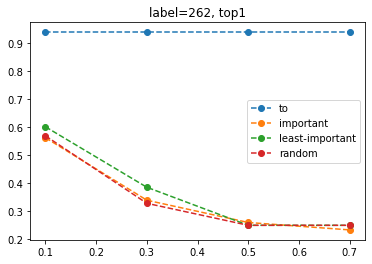

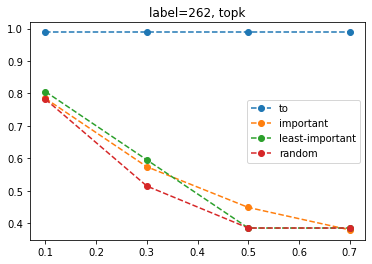

In [50]:
label = 262
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

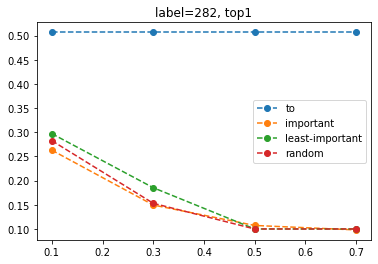

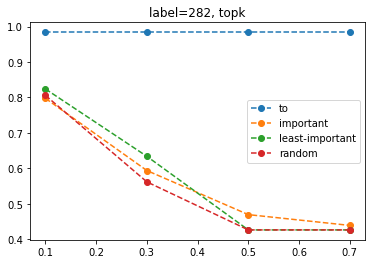

In [53]:
label = 282
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

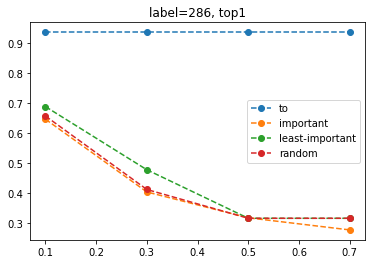

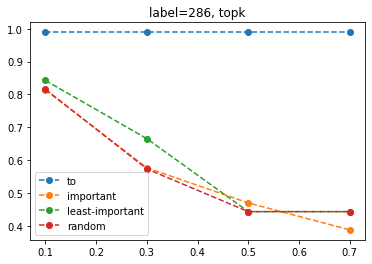

In [54]:
label = 286
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

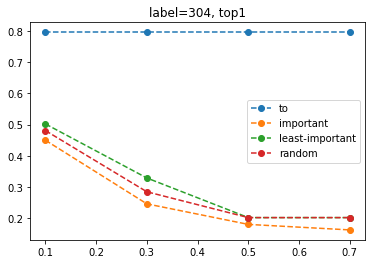

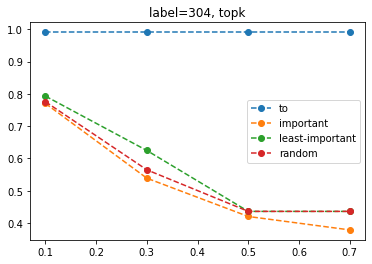

In [55]:
label = 304
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

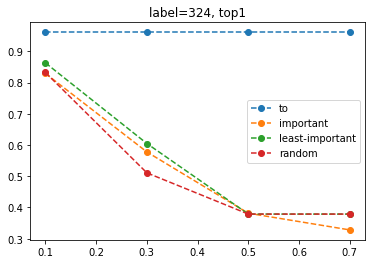

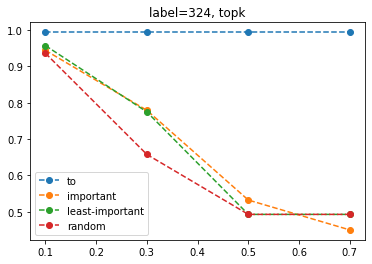

In [56]:
label = 324
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

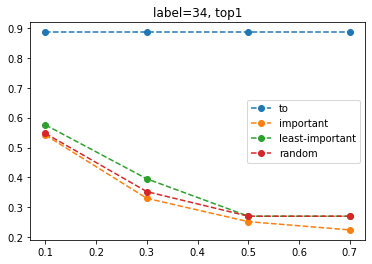

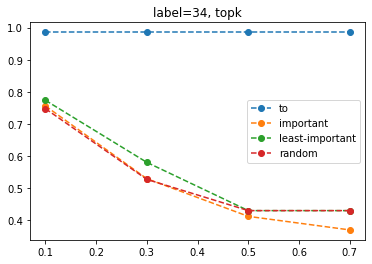

In [57]:
label = 34
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

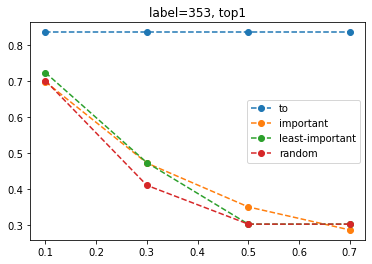

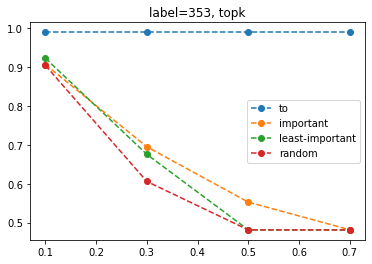

In [58]:
label = 353
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

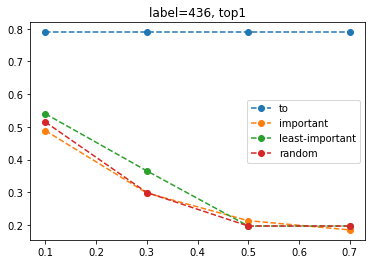

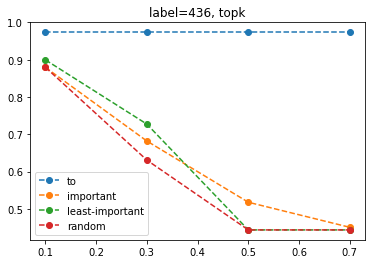

In [59]:
label = 436
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

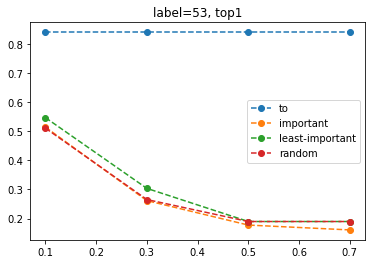

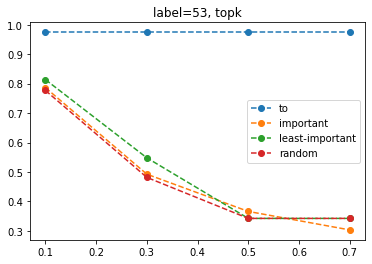

In [60]:
label = 53
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

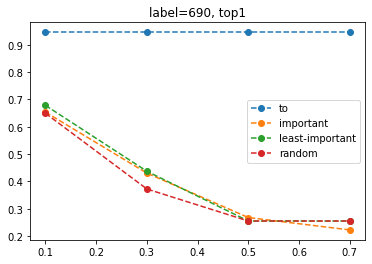

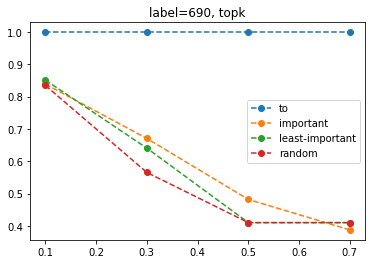

In [61]:
label = 690
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

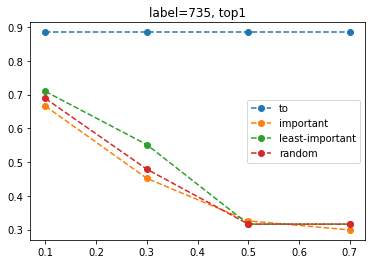

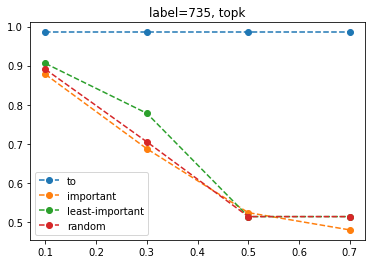

In [63]:
label = 735
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

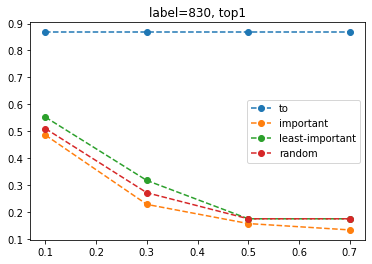

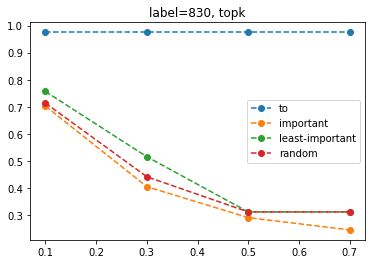

In [64]:
label = 830
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

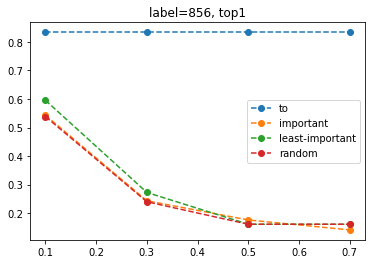

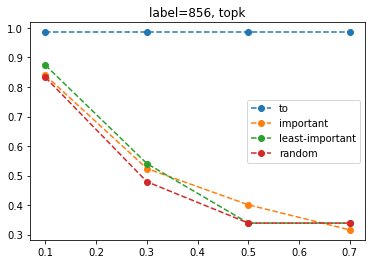

In [65]:
label = 856
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

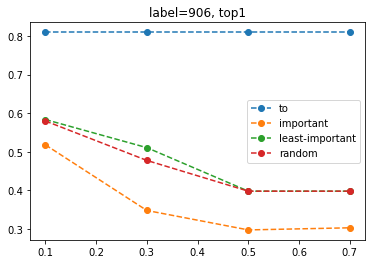

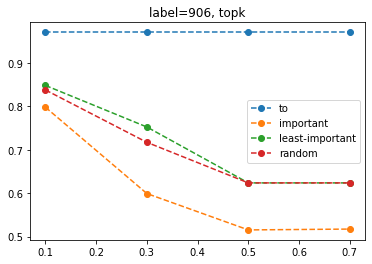

In [67]:
label = 906
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

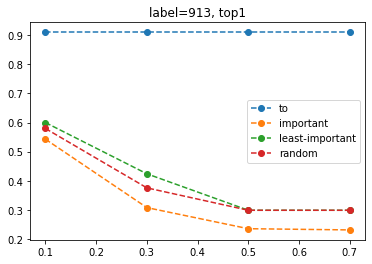

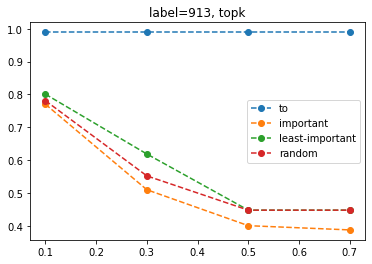

In [68]:
label = 913
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

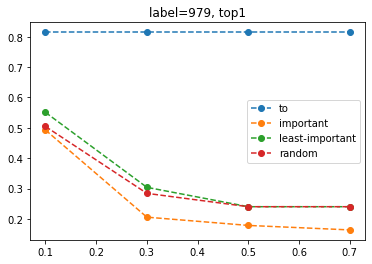

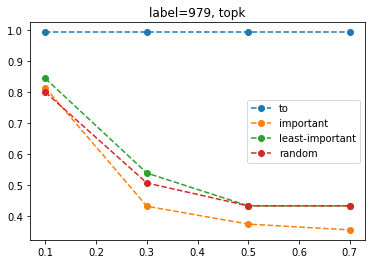

In [69]:
label = 979
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

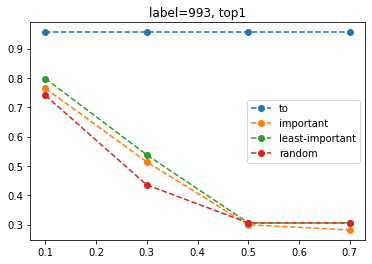

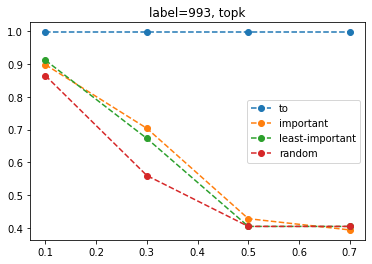

In [71]:
label = 993
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data)

## InceptionV3, 11-> 121, perturbation

In [81]:
input_dir = '../../data/eval_important_evo'
# models = ['inception_v3-512-0.5-0.9', 'vgg16-512-0.01-0.9']
models = ['inception_v3-512-0.5-0.9']

eval_type = 'perturbation'
from_tos = {
    'inception_v3-512-0.5-0.9': ['inception_v3_512_0.5_0.9_11', 'inception_v3_512_0.5_0.9_121'],
    'vgg16-512-0.01-0.9': ['vgg16_512_0.01_0.9_21', 'vgg16_512_0.01_0.9_207']
}

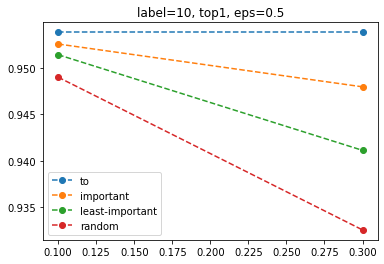

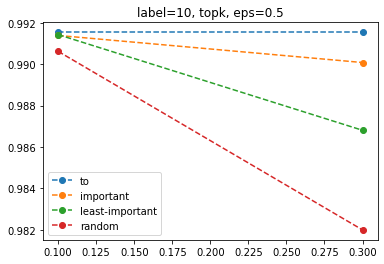

In [85]:
label = 10
eps = 0.5
eval_sample_ratios = [0.1, 0.3]
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data, eval_type=eval_type, eps=eps)

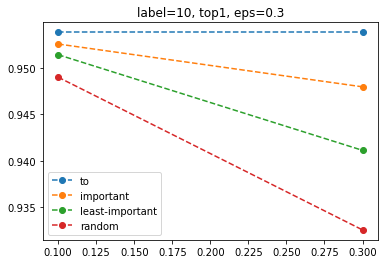

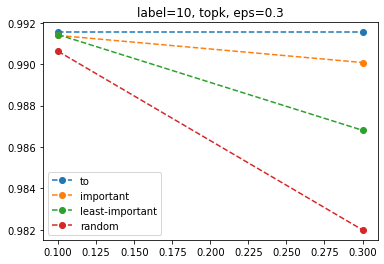

In [86]:
label = 10
eps = 0.3
eval_sample_ratios = [0.1, 0.3]
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data, eval_type=eval_type, eps=eps)

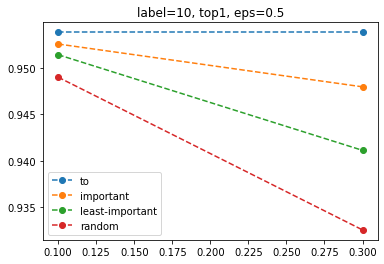

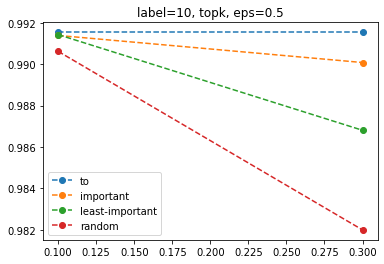

In [87]:
label = 10
eps = 0.5
eval_sample_ratios = [0.1, 0.3]
model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos)
draw_graph(label, model_data, eval_type=eval_type, eps=eps)